# Assignment 1: Multi-Layer Perceptron with MNIST Dataset

In this assignment, you are required to train two MLPs to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database by using PyTorch.

The process will be broken down into the following steps:
>1. Load and visualize the data.
2. Define a neural network. (30 marks)
3. Train the models. (30 marks)
4. Evaluate the performance of our trained models on the test dataset. (20 marks)
5. Analysis your results. (20 marks)

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
def classify_label(dataset, num_classes):
    list_index = [[] for _ in range(num_classes)]
    for idx, datum in enumerate(dataset):
        list_index[datum[1]].append(idx)
    return list_index

def partition_train(list_label2indices: list, num_per_class: int):
    random_state = np.random.RandomState(0)
    list_label2indices_train = []
    for indices in list_label2indices:
        random_state.shuffle(indices)
        list_label2indices_train.extend(indices[:num_per_class])
    return list_label2indices_train

class Indices2Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = None

    def load(self, indices: list):
        self.indices = indices

    def __getitem__(self, idx):
        idx = self.indices[idx]
        image, label = self.dataset[idx]
        return image, label

    def __len__(self):
        return len(self.indices)

#  sort train data by label
list_label2indices = classify_label(dataset=train_data, num_classes=10)

# how many samples per class to train
list_train = partition_train(list_label2indices, 500)

# prepare data loaders  
indices2data = Indices2Dataset(train_data)
indices2data.load(list_train)
train_loader = torch.utils.data.DataLoader(indices2data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

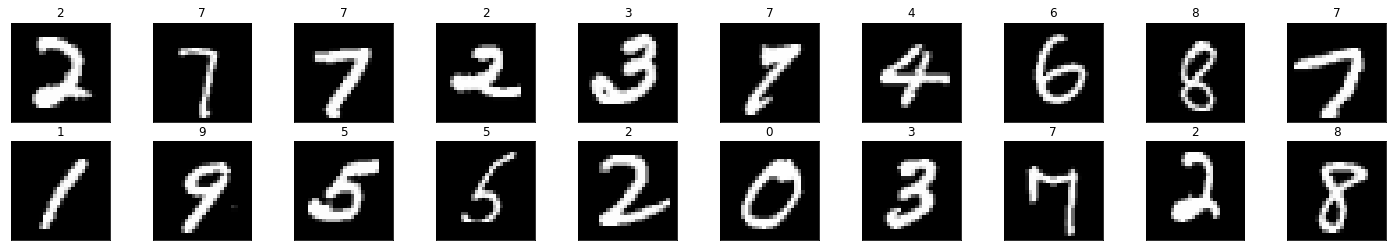

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

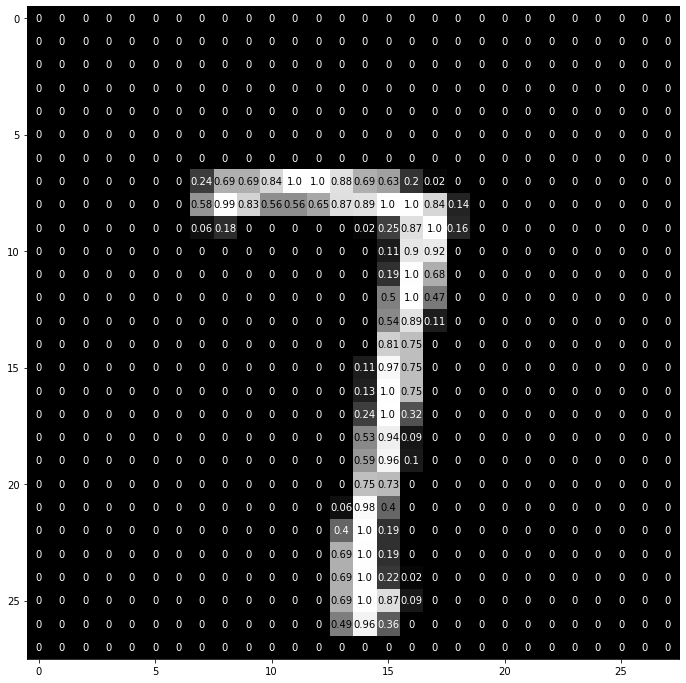

In [5]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network Architecture (30 marks)

* Input: a 784-dim Tensor of pixel values for each image.
* Output: a 10-dim Tensor of number of classes that indicates the class scores for an input image. 

You need to implement three models:
1. a vanilla multi-layer perceptron. (10 marks)
2. a multi-layer perceptron with regularization (dropout or L2 or both). (10 marks)
3. the corresponding loss functions and optimizers. (10 marks)

### Build model_1

In [6]:
## Define the MLP architecture
class VanillaMLP(nn.Module):
    def __init__(self):
        super(VanillaMLP, self).__init__()
        
        # 定义一个三层的网络，包含两个全连接层，一个输出层
        self.fc1 = nn.Linear(784, 512)    # 第一层输入：784 输出：512
        self.fc2 = nn.Linear(512, 512)    # 第二层输出：512 输出：512
        self.fc3 = nn.Linear(512, 10)     # 输出层输入：512 输出：10

    # 前向传播函数    
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)

        # relu激活
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # 输出层不用relu，使用softmax
        x = F.softmax(self.fc3(x), dim=1)

        return x

# initialize the MLP
model_1 = VanillaMLP()

# specify loss function：交叉熵损失
loss_function_1 = nn.CrossEntropyLoss()

# specify your optimizer：随机梯度下降 学习率：0.01
optimizer_1 = optim.SGD(params=model_1.parameters(), lr=0.01)

### Build model_2

In [7]:
## Define the MLP architecture
class RegularizedMLP(nn.Module):
    def __init__(self):
        super(RegularizedMLP, self).__init__()
        
        # 定义一个三层的网络，包含两个全连接层，一个输出层
        self.fc1 = nn.Linear(784, 512)    # 第一层输入：784 输出：512
        self.fc2 = nn.Linear(512, 512)    # 第二层输出：512 输出：512
        self.fc3 = nn.Linear(512, 10)     # 输出层输入：512 输出：10
        # 设置dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)

        # relu激活
        x = F.relu(self.fc1(x))
        # 引入dropout防止过拟合
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # 输出层不用relu，使用softmax
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

# initialize the MLP
model_2 = RegularizedMLP()

# specify loss function：交叉熵损失
loss_function_2 = nn.CrossEntropyLoss()

# specify your optimizer：随机梯度下降 学习率：0.01
optimizer_2 = optim.SGD(params=model_2.parameters(), lr=0.01)

---
## Train the Network (30 marks)

Train your models in the following two cells.

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

**The key parts in the training process are left for you to implement.**

### Train model_1

In [8]:
# number of epochs to train the model
n_epochs = 100  # suggest training between 100-150 epochs

# 绘图用的数据
train_loss_epochs_1 = []
train_acc_epochs_1 = []
test_loss_epochs_1 = []
test_acc_epochs_1 = []

# 模型训练
for epoch in range(n_epochs):
    model_1.train() # prep model for training
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    
    for data, target in train_loader:
        
        # 模型参数梯度置0
        optimizer_1.zero_grad()
        # 获取这一轮预测值
        output = model_1(data)
        # 计算预测值与真实值之间的差别
        loss = loss_function_1(output, target)
        # 反向传播，计算新的模型参数
        loss.backward()
        # 优化器更新网络参数
        optimizer_1.step()

        train_loss += loss.item() * data.size(0) # the total loss of this batch
        # 找到输出中概率值最大的下标
        predict = output.argmax(dim=1)
        total_correct += (predict == target).sum()# the accumulated number of correctly classified samples of this batch

    # print training statistics 
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)
    
    
    # model_1训练过程引入测试集，用于判定模型是否过拟合
    model_1.eval()
    test_loss = 0.0
    correct = 0.0
    for data, target in test_loader:
        
        # 获得模型的预测值
        output = model_1(data)
        # 计算测试loss
        test_loss += loss_function_1(output, target).item() * data.size(0) # the total loss of this batch

        # 找到预测概率最大的下标
        predict = output.argmax(dim=1)
        correct += (predict == target).sum()
        
    # 计算测试损失和准确率
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('Epoch:{}  Training Loss: {:.6f}  Training Acc: {:.2f}%  Test Loss: {:.6f}  Test Acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        train_acc,
        test_loss, 
        test_acc))
    
    # 保存该epoch下的train_loss train_acc test_loss test_acc  
    train_loss_epochs_1.append(train_loss)
    train_acc_epochs_1.append(train_acc / 100)
    test_loss_epochs_1.append(test_loss)
    test_acc_epochs_1.append(test_acc / 100)

Epoch:1  Training Loss: 2.302737  Training Acc: 9.92%  Test Loss: 2.302187  Test Acc: 14.13%
Epoch:2  Training Loss: 2.301507  Training Acc: 16.12%  Test Loss: 2.300942  Test Acc: 18.06%
Epoch:3  Training Loss: 2.300206  Training Acc: 19.88%  Test Loss: 2.299597  Test Acc: 19.19%
Epoch:4  Training Loss: 2.298768  Training Acc: 20.80%  Test Loss: 2.298074  Test Acc: 19.32%
Epoch:5  Training Loss: 2.297094  Training Acc: 19.80%  Test Loss: 2.296258  Test Acc: 17.85%
Epoch:6  Training Loss: 2.295034  Training Acc: 18.32%  Test Loss: 2.293955  Test Acc: 15.52%
Epoch:7  Training Loss: 2.292297  Training Acc: 14.82%  Test Loss: 2.290752  Test Acc: 12.56%
Epoch:8  Training Loss: 2.288182  Training Acc: 12.10%  Test Loss: 2.285560  Test Acc: 10.53%
Epoch:9  Training Loss: 2.280522  Training Acc: 10.40%  Test Loss: 2.274869  Test Acc: 9.84%
Epoch:10  Training Loss: 2.265048  Training Acc: 10.04%  Test Loss: 2.257152  Test Acc: 9.83%
Epoch:11  Training Loss: 2.248197  Training Acc: 13.36%  Test 

### Train model_2

In [9]:
# number of epochs to train the model
n_epochs = 100  # suggest training between 100-150 epochs
# 绘图用的数据
train_loss_epochs_2 = []
train_acc_epochs_2 = []
test_loss_epochs_2 = []
test_acc_epochs_2 = []

# 模型训练
for epoch in range(n_epochs):
    model_2.train() # prep model for training
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    
    for data, target in train_loader:
        # 模型参数梯度置0
        optimizer_2.zero_grad()
        # 获取这一轮预测值
        output = model_2(data)
        # 计算预测值与真实值之间的差别
        loss = loss_function_2(output, target)
        # 反向传播，计算新的模型参数
        loss.backward()
        # 优化器更新网络参数
        optimizer_2.step()

        train_loss += loss.item() * data.size(0) # the total loss of this batch
        # 找到输出中概率值最大的下标
        predict = output.argmax(dim=1)
        total_correct += (predict == target).sum()# the accumulated number of correctly classified samples of this batch
        
    # print training statistics 
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)
    
    
    # model_2训练过程引入测试集，用于判定模型是否过拟合
    model_2.eval()
    test_loss = 0.0
    correct = 0.0
    for data, target in test_loader:
        # 获得模型的预测值
        output = model_2(data)
        # 计算测试loss
        test_loss += loss_function_2(output, target).item() * data.size(0) # the total loss of this batch

        # 找到预测概率最大的下标
        predict = output.argmax(dim=1)
        correct += (predict == target).sum()
        
    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('Epoch:{}  Training Loss: {:.6f}  Training Acc: {:.2f}%  Test Loss: {:.6f}  Test Acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        train_acc,
        test_loss, 
        test_acc))
    
    # 保存该epoch下的train_loss train_acc test_loss test_acc  
    train_loss_epochs_2.append(train_loss)
    train_acc_epochs_2.append(train_acc / 100)
    test_loss_epochs_2.append(test_loss)
    test_acc_epochs_2.append(test_acc / 100)

Epoch:1  Training Loss: 2.301971  Training Acc: 13.08%  Test Loss: 2.301436  Test Acc: 12.76%
Epoch:2  Training Loss: 2.300797  Training Acc: 16.20%  Test Loss: 2.300195  Test Acc: 17.69%
Epoch:3  Training Loss: 2.299646  Training Acc: 18.76%  Test Loss: 2.298827  Test Acc: 24.90%
Epoch:4  Training Loss: 2.298219  Training Acc: 25.34%  Test Loss: 2.297253  Test Acc: 30.06%
Epoch:5  Training Loss: 2.296611  Training Acc: 30.22%  Test Loss: 2.295393  Test Acc: 32.58%
Epoch:6  Training Loss: 2.294618  Training Acc: 31.30%  Test Loss: 2.293074  Test Acc: 32.65%
Epoch:7  Training Loss: 2.292094  Training Acc: 31.10%  Test Loss: 2.289992  Test Acc: 30.67%
Epoch:8  Training Loss: 2.288357  Training Acc: 27.74%  Test Loss: 2.285374  Test Acc: 25.18%
Epoch:9  Training Loss: 2.282380  Training Acc: 21.06%  Test Loss: 2.276865  Test Acc: 16.24%
Epoch:10  Training Loss: 2.269400  Training Acc: 14.02%  Test Loss: 2.259796  Test Acc: 12.09%
Epoch:11  Training Loss: 2.251225  Training Acc: 13.42%  Te

### Plot accuracy and loss curves of model_1 and model_2

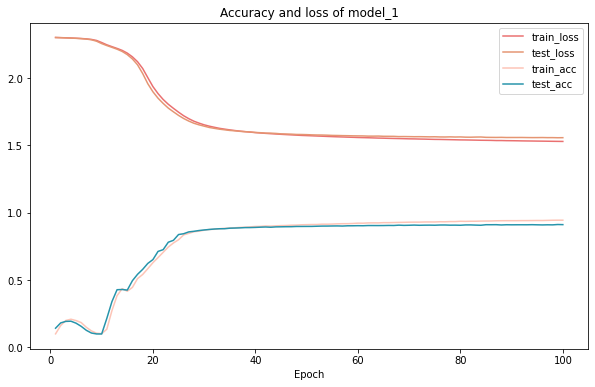

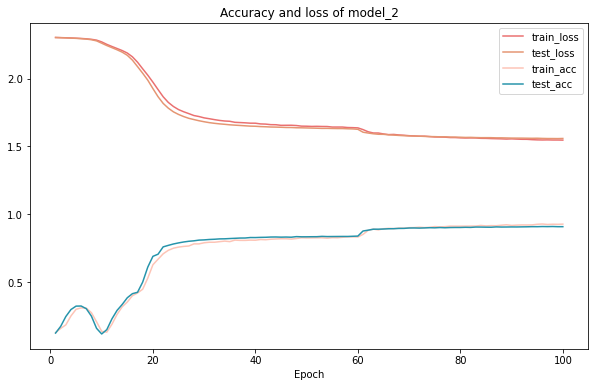

In [10]:
# model_1绘图
epochs = [i for i in range(1, 101)]
plt.figure(figsize = (10,6)) 
l1, = plt.plot(epochs, train_loss_epochs_1, color='#ea7070', label='train_loss')
l2, = plt.plot(epochs, train_acc_epochs_1, color='#fdc4b6', label='train_acc')
l3, = plt.plot(epochs, test_loss_epochs_1, color='#e59572', label='test_loss')
l4, = plt.plot(epochs, test_acc_epochs_1, color='#2694ab', label='test_acc')
plt.legend(handles=[l1, l3, l2, l4], labels=['train_loss', 'test_loss', 'train_acc', 'test_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy and loss of model_1')
plt.show()
# model_2绘图
plt.figure(figsize = (10,6)) 
l1, = plt.plot(epochs, train_loss_epochs_2, color='#ea7070', label='train_loss')
l2, = plt.plot(epochs, train_acc_epochs_2, color='#fdc4b6', label='train_acc')
l3, = plt.plot(epochs, test_loss_epochs_2, color='#e59572', label='test_loss')
l4, = plt.plot(epochs, test_acc_epochs_2, color='#2694ab', label='test_acc')
plt.legend(handles=[l1, l3, l2, l4], labels=['train_loss', 'test_loss', 'train_acc', 'test_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy and loss of model_2')
plt.show()

---
## Test the Trained Network (20 marks)

Test the performance of trained models on test data. Except the total test accuracy, you should calculate the accuracy for each class.

### Test model_1

In [11]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
conf_matrix_1 = torch.zeros(10, 10)

model_1.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    # 获得模型的预测值
    output = model_1(data)
    # 计算测试loss
    test_loss += loss_function_1(output, target).item() * data.size(0) # the total loss of this batch

    # 找到预测概率最大的下标
    predict = output.argmax(dim=1)
    correct = np.squeeze(predict.eq(target.data.view_as(predict)))
    for i in range(batch_size):
      label = target.data[i]
      class_correct[label] += correct[i].item() # the list of number of correctly classified samples of each class of this batch. label is the index.
      class_total[label] += 1 # the list of total number of samples of each class of this batch. label is the index.
    
    # 计算混淆矩阵
    for x, y in zip(predict, target):
      conf_matrix_1[x, y] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
    else:
        print('Test Accuracy of class %d: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %.2f%%' % (100. * np.sum(class_correct) / np.sum(class_total)))

Test Loss: 1.557732

Test Accuracy of class 0: 96.84%
Test Accuracy of class 1: 97.36%
Test Accuracy of class 2: 86.92%
Test Accuracy of class 3: 91.39%
Test Accuracy of class 4: 93.38%
Test Accuracy of class 5: 83.97%
Test Accuracy of class 6: 93.74%
Test Accuracy of class 7: 91.73%
Test Accuracy of class 8: 87.27%
Test Accuracy of class 9: 87.31%

Test Accuracy (Overall): 91.12%


### Test model_2

In [12]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
conf_matrix_2 = torch.zeros(10, 10)

model_2.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    # 获得模型的预测值
    output = model_2(data)
    
    test_loss += loss_function_2(output, target).item() * data.size(0) # the total loss of this batch
    # 找到预测概率最大的下标
    predict = output.argmax(dim=1)
    correct = np.squeeze(predict.eq(target.data.view_as(predict)))
    for i in range(batch_size):
      label = target.data[i]
      class_correct[label] += correct[i].item() # the list of number of correctly classified samples of each class of this batch. label is the index.
      class_total[label] += 1 # the list of total number of samples of each class of this batch. label is the index.

    # 计算混淆矩阵
    for x, y in zip(predict, target):
      conf_matrix_2[x, y] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
    else:
        print('Test Accuracy of class %d: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %.2f%%' % (100. * np.sum(class_correct) / np.sum(class_total)))

Test Loss: 1.558990

Test Accuracy of class 0: 96.84%
Test Accuracy of class 1: 97.62%
Test Accuracy of class 2: 86.63%
Test Accuracy of class 3: 87.13%
Test Accuracy of class 4: 94.09%
Test Accuracy of class 5: 83.86%
Test Accuracy of class 6: 95.30%
Test Accuracy of class 7: 92.61%
Test Accuracy of class 8: 87.27%
Test Accuracy of class 9: 87.61%

Test Accuracy (Overall): 91.02%


### Compare models

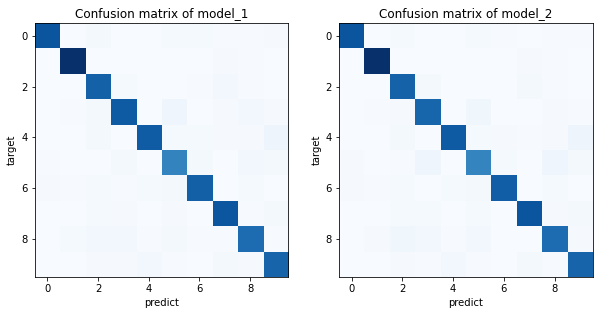

In [13]:
# 绘制混淆矩阵
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_1, cmap=plt.cm.Blues)
plt.title('Confusion matrix of model_1')
plt.xlabel('predict')
plt.ylabel('target')
plt.subplot(1, 2, 2)
plt.imshow(conf_matrix_2, cmap=plt.cm.Blues)
plt.title('Confusion matrix of model_2')
plt.xlabel('predict')
plt.ylabel('target')
plt.show()

---
## Analyze Your Result (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Does your vanilla MLP overfit to the training data? (5 marks)

Answer:没有。

2. If yes, how do you observe it? If no, why? (5 marks)

Answer:通过观察每个epoch训练过程中的损失（loss）和准确率（accuracy）以及对应测试的loss和accuracy数据，配合参考绘制的loss和accuracy曲线图，训练和测试过程loss均慢慢减小，并且曲线比较相近，训练和测试的accuracy差别也不大，因此判断model_1未出现过拟合现象。

3. Is regularized model help prevent overfitting? (5 marks)

Answer:在我建立的模型中，使用Dropout正则化操作没有对模型的过拟合起到明显的效果，不过在理论上，model_2相比model_1在模型结构上，增加了Dropout层，为每个神经元结点设置一个随机消除的概率，可以降低模型的复杂性，有效地防止过拟合现象。在模型训练的后期，model_2的训练与测试的loss曲线和accuracy曲线吻合程度更高。
4. Generally compare the performance of two models. (5 marks)

Answer:
- （1）准确率上，model_2在测试集上的平均准确率为91.02%，略低于model_1的准确率91.12%，但是差别比较小。
- （2）混淆矩阵上，model_1和model_2均在对角线上颜色深，表明两个模型的分类效果都比较好
- （3）每个类别的准确率上，model_1和model_2的表现均出较高的准确率

| label | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| model_1 | 96.84% | 97.36% | 86.92% | 91.39% | 93.38% | 83.97% | 93.74% | 91.73% | 87.27% | 87.31% |
| model_2 | 96.84% |  97.62% | 86.63% | 87.13% | 94.09% | 83.86% | 95.30% | 92.61% | 87.27% | 87.61% |

- （4）综上，两个模型在mnist数据集上的表现良好
